In [1]:
from common import colors, pvalue_thresholds, sbarlw, savefig

In [2]:
from __future__ import division

import os; os.chdir(os.path.join('..', '..', '..'))
print os.getcwd()

/home/eharkin/projects/5HTGIF-dev


In [3]:
import warnings
import re
import copy
import pickle

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.interpolate import griddata
from tqdm.notebook import tqdm, trange

from ezephys import pltools
from statannot import add_stat_annotation

from grr.Simulation import GIFnet_Simulation
from grr.GainEstimator import GainEstimator
from grr.Tools import raiseExpectedGot, timeToIndex, reprint
from grr.Spiketrain import PSTH
from grr.CurveFit import plot_linear_fit

In [4]:
plt.style.use(os.path.join('figs', 'scripts', 'writeup', 'publication_figure_style.dms'))
IMG_PATH = os.path.join('figs', 'ims', 'writeup', 'GIF_network')
BASELINE_LEVELS = np.array([-0.080, -0.060, -0.040, -0.020, 0, 0.020, 0.040, 0.060, 0.080])

In [6]:
DATA_PATH = os.path.join('data', 'simulations', 'GIF_network')

sim_dict = {'Baseline level': [], 'Rep': [], 'Model': [], 'IA': [], 'Adaptation': [], 'DV': []}

for condition in os.listdir(DATA_PATH):
    if not condition.startswith('deriv_input'):
        continue
        
    for baseline_level in ['-0.080', '-0.060', '-0.040', '-0.020', '0.000', '0.020', '0.040', '0.060', '0.080']:
        for fname in os.listdir(os.path.join(DATA_PATH, condition, '{}_baseline'.format(baseline_level))):
            if fname.endswith(('hdf5', 'h5')):

                try:
                    this_model = GIFnet_Simulation(
                        os.path.join(DATA_PATH, condition, '{}_baseline'.format(baseline_level), fname), 
                        mode = 'r'
                    ) 

                    sim_dict['Model'].append(this_model)
                    sim_dict['Baseline level'].append(float(baseline_level))
                    sim_dict['Rep'].append(
                        int(re.search(r'rep([0-9]+)', fname).groups()[-1])
                    )
                    
                    if 'ia_ko' in condition:
                        sim_dict['IA'].append('KO')
                    else:
                        sim_dict['IA'].append('CTRL')
                    if 'adaptation' in condition:
                        sim_dict['Adaptation'].append('swap_ser_only')
                    else:
                        sim_dict['Adaptation'].append('CTRL')
                    if 'dv' in condition:
                        sim_dict['DV'].append('swap_ser_only')
                    else:
                        sim_dict['DV'].append('CTRL')
                except IOError:
                    print('Problem with {} baseline {}'.format(baseline_level, fname))
                    continue
            

sim_df = pd.DataFrame(sim_dict).sort_values(['Rep'])
sim_df.reset_index(inplace=True, drop=True)
sim_df.head()

,Adaptation,Baseline level,DV,IA,Model,Rep
0,CTRL,-0.08,CTRL,CTRL,"[connectivity_matrix, gaba, ser]",0
1,CTRL,-0.04,CTRL,KO,"[connectivity_matrix, gaba, ser]",0
2,swap_ser_only,-0.04,CTRL,CTRL,"[connectivity_matrix, gaba, ser]",0
3,CTRL,-0.02,CTRL,KO,"[connectivity_matrix, gaba, ser]",0
4,CTRL,-0.06,swap_ser_only,CTRL,"[connectivity_matrix, gaba, ser]",0


In [7]:
sim_df['Principal PSTH'] = None
sim_df['Principal PSTH'] = sim_df['Principal PSTH'].astype(object)
sim_df['GABA PSTH'] = None
sim_df['GABA PSTH'] = sim_df['GABA PSTH'].astype(object)

In [ ]:
PSTH_width = 50.

for i in trange(sim_df.shape[0], desc='Model'):
    
    # Get PSTH from 5HT population.
    sim_df.at[i, 'Principal PSTH'] = np.empty((
        sim_df.loc[i, 'Model'].get_no_sweeps(), 
        sim_df.loc[i, 'Model'].get_no_timesteps()
    ))
    for sweep_no in trange(sim_df.loc[i, 'Model'].get_no_sweeps(), desc='5HT sweep', leave=False):
        sim_df.loc[i, 'Principal PSTH'][sweep_no, :] = PSTH(
            sim_df.loc[i, 'Model'].ser_spktrains[sweep_no, ...].sum(axis = 0),
            PSTH_width,
            sim_df.loc[i, 'Model'].get_no_ser_neurons()
        )
    
    # Get PSTHs from GABA population.
    sim_df.at[i, 'GABA PSTH'] = np.empty((
        sim_df.loc[i, 'Model'].get_no_sweeps(), 
        sim_df.loc[i, 'Model'].get_no_timesteps()
    ))
    for sweep_no in trange(sim_df.loc[i, 'Model'].get_no_sweeps(), desc='GABA sweep', leave=False):
        sim_df.loc[i, 'GABA PSTH'][sweep_no, :] = PSTH(
            sim_df.loc[i, 'Model'].gaba_spktrains[sweep_no, ...].sum(axis = 0),
            PSTH_width,
            sim_df.loc[i, 'Model'].get_no_gaba_neurons()
        )

print('\nDone!')

SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnTW9kZWwnLCBtYXg9OTAwLjAsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGVzY3JpcHRpb25fd2lkdGjigKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnNUhUIHN3ZWVwJywgbWF4PTIwLjAsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGVzY3JpcHRpb25fd2nigKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnR0FCQSBzd2VlcCcsIG1heD0yMC4wLCBzdHlsZT1Qcm9ncmVzc1N0eWxlKGRlc2NyaXB0aW9uX3figKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnNUhUIHN3ZWVwJywgbWF4PTIwLjAsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGVzY3JpcHRpb25fd2nigKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnR0FCQSBzd2VlcCcsIG1heD0yMC4wLCBzdHlsZT1Qcm9ncmVzc1N0eWxlKGRlc2NyaXB0aW9uX3figKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnNUhUIHN3ZWVwJywgbWF4PTIwLjAsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGVzY3JpcHRpb25fd2nigKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnR0FCQSBzd2VlcCcsIG1heD0yMC4wLCBzdHlsZT1Qcm9ncmVzc1N0eWxlKGRlc2NyaXB0aW9uX3figKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnNUhUIHN3ZWVwJywgbWF4PTIwLjAsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGVzY3JpcHRpb25fd2nigKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnR0FCQSBzd2VlcCcsIG1heD0yMC4wLCBzdHlsZT1Qcm9ncmVzc1N0eWxlKGRlc2NyaXB0aW9uX3figKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnNUhUIHN3ZWVwJywgbWF4PTIwLjAsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGVzY3JpcHRpb25fd2nigKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnR0FCQSBzd2VlcCcsIG1heD0yMC4wLCBzdHlsZT1Qcm9ncmVzc1N0eWxlKGRlc2NyaXB0aW9uX3figKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnNUhUIHN3ZWVwJywgbWF4PTIwLjAsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGVzY3JpcHRpb25fd2nigKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnR0FCQSBzd2VlcCcsIG1heD0yMC4wLCBzdHlsZT1Qcm9ncmVzc1N0eWxlKGRlc2NyaXB0aW9uX3figKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnNUhUIHN3ZWVwJywgbWF4PTIwLjAsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGVzY3JpcHRpb25fd2nigKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnR0FCQSBzd2VlcCcsIG1heD0yMC4wLCBzdHlsZT1Qcm9ncmVzc1N0eWxlKGRlc2NyaXB0aW9uX3figKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnNUhUIHN3ZWVwJywgbWF4PTIwLjAsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGVzY3JpcHRpb25fd2nigKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnR0FCQSBzd2VlcCcsIG1heD0yMC4wLCBzdHlsZT1Qcm9ncmVzc1N0eWxlKGRlc2NyaXB0aW9uX3figKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnNUhUIHN3ZWVwJywgbWF4PTIwLjAsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGVzY3JpcHRpb25fd2nigKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnR0FCQSBzd2VlcCcsIG1heD0yMC4wLCBzdHlsZT1Qcm9ncmVzc1N0eWxlKGRlc2NyaXB0aW9uX3figKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnNUhUIHN3ZWVwJywgbWF4PTIwLjAsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGVzY3JpcHRpb25fd2nigKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnR0FCQSBzd2VlcCcsIG1heD0yMC4wLCBzdHlsZT1Qcm9ncmVzc1N0eWxlKGRlc2NyaXB0aW9uX3figKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnNUhUIHN3ZWVwJywgbWF4PTIwLjAsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGVzY3JpcHRpb25fd2nigKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnR0FCQSBzd2VlcCcsIG1heD0yMC4wLCBzdHlsZT1Qcm9ncmVzc1N0eWxlKGRlc2NyaXB0aW9uX3figKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnNUhUIHN3ZWVwJywgbWF4PTIwLjAsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGVzY3JpcHRpb25fd2nigKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnR0FCQSBzd2VlcCcsIG1heD0yMC4wLCBzdHlsZT1Qcm9ncmVzc1N0eWxlKGRlc2NyaXB0aW9uX3figKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnNUhUIHN3ZWVwJywgbWF4PTIwLjAsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGVzY3JpcHRpb25fd2nigKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnR0FCQSBzd2VlcCcsIG1heD0yMC4wLCBzdHlsZT1Qcm9ncmVzc1N0eWxlKGRlc2NyaXB0aW9uX3figKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnNUhUIHN3ZWVwJywgbWF4PTIwLjAsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGVzY3JpcHRpb25fd2nigKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnR0FCQSBzd2VlcCcsIG1heD0yMC4wLCBzdHlsZT1Qcm9ncmVzc1N0eWxlKGRlc2NyaXB0aW9uX3figKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnNUhUIHN3ZWVwJywgbWF4PTIwLjAsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGVzY3JpcHRpb25fd2nigKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnR0FCQSBzd2VlcCcsIG1heD0yMC4wLCBzdHlsZT1Qcm9ncmVzc1N0eWxlKGRlc2NyaXB0aW9uX3figKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnNUhUIHN3ZWVwJywgbWF4PTIwLjAsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGVzY3JpcHRpb25fd2nigKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnR0FCQSBzd2VlcCcsIG1heD0yMC4wLCBzdHlsZT1Qcm9ncmVzc1N0eWxlKGRlc2NyaXB0aW9uX3figKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnNUhUIHN3ZWVwJywgbWF4PTIwLjAsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGVzY3JpcHRpb25fd2nigKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnR0FCQSBzd2VlcCcsIG1heD0yMC4wLCBzdHlsZT1Qcm9ncmVzc1N0eWxlKGRlc2NyaXB0aW9uX3figKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnNUhUIHN3ZWVwJywgbWF4PTIwLjAsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGVzY3JpcHRpb25fd2nigKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnR0FCQSBzd2VlcCcsIG1heD0yMC4wLCBzdHlsZT1Qcm9ncmVzc1N0eWxlKGRlc2NyaXB0aW9uX3figKY=


SEJveChjaGlsZHJlbj0oRmxvYXRQcm9ncmVzcyh2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnNUhUIHN3ZWVwJywgbWF4PTIwLjAsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGVzY3JpcHRpb25fd2nigKY=


In [9]:
sim_df.head()

,Adaptation,Baseline level,DV,IA,Model,Rep,Principal PSTH,GABA PSTH
0,CTRL,-0.08,CTRL,CTRL,"[connectivity_matrix, gaba, ser]",0,"[[0.10000000894069672, 0.10000000894069672, 0....","[[0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0...."
1,CTRL,-0.04,CTRL,KO,"[connectivity_matrix, gaba, ser]",0,"[[0.1666666716337204, 0.1666666716337204, 0.16...","[[0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0...."
2,swap_ser_only,-0.04,CTRL,CTRL,"[connectivity_matrix, gaba, ser]",0,"[[0.13333334028720856, 0.13333334028720856, 0....","[[0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0...."
3,CTRL,-0.02,CTRL,KO,"[connectivity_matrix, gaba, ser]",0,"[[0.20000000298023224, 0.20000000298023224, 0....","[[0.8500000834465027, 0.8500000834465027, 0.85..."
4,CTRL,-0.06,swap_ser_only,CTRL,"[connectivity_matrix, gaba, ser]",0,"[[1.333333134651184, 1.333333134651184, 1.3333...","[[0.30000001192092896, 0.30000001192092896, 0...."


In [ ]:
psths = []
for i, row in sim_df.loc[sim_df['Baseline level'] == 0.040, ['Rep', 'Principal PSTH', 'GABA PSTH']].iterrows():
    psths.append(row['Principal PSTH'].T)
    
psths = np.array(psths)

plt.plot(psths.mean(axis=0))

In [10]:
BASELINE_LEVELS = np.array([-0.080, -0.060, -0.040, -0.020, 0, 0.020, 0.040, 0.060, 0.080])

def get_psth_max_by_celltype(df):
    max_resp = {key: np.empty((20, len(BASELINE_LEVELS))) for key in ['ser', 'som']}
    max_resp_std = {key: np.empty((20, len(BASELINE_LEVELS))) for key in ['ser', 'som']}
    for i, baseline in enumerate(BASELINE_LEVELS):

        psths = {key: [] for key in max_resp.keys()}
        for _, row in df.loc[df['Baseline level'] == baseline, ['Rep', 'Principal PSTH', 'GABA PSTH']].iterrows():
            psths['ser'].append(row['Principal PSTH'])
            psths['som'].append(row['GABA PSTH'])

        for key in max_resp:
            max_resp[key][:, i] = np.asarray(psths[key])[:, :, 19000:].max(axis=2).mean(axis=0)
            max_resp_std[key][:, i] = np.asarray(psths[key])[:, :, 19000:].max(axis=2).std(axis=0)

    for key in max_resp:
        max_resp[key] = max_resp[key].T
        max_resp_std[key] = max_resp_std[key].T
        
    return {ct: {'mean': max_resp[ct], 'std': max_resp_std[ct]} for ct in ['ser', 'som']}

In [11]:
max_resp = {
    'ctrl': get_psth_max_by_celltype(
        sim_df.query('(Adaptation == "CTRL") and (DV == "CTRL") and (IA == "CTRL")')
    ),
    'dv': get_psth_max_by_celltype(
        sim_df.query('(Adaptation == "CTRL") and (DV == "swap_ser_only") and (IA == "CTRL")')
    ),
    'adaptation': get_psth_max_by_celltype(
        sim_df.query('(Adaptation == "swap_ser_only") and (DV == "CTRL") and (IA == "CTRL")')
    ),
    'dv_adaptation': get_psth_max_by_celltype(
        sim_df.query('(Adaptation == "swap_ser_only") and (DV == "swap_ser_only") and (IA == "CTRL")')
    ),
    'ia': get_psth_max_by_celltype(
        sim_df.query('(Adaptation == "CTRL") and (DV == "CTRL") and (IA == "KO")')
    ),
}

# Cache results

In [5]:
cache_path = os.path.join('data', 'processed', 'simulations', 'max_deriv_response_all_conditions.dat')
if os.path.exists(cache_path):
    print('Loading.')
    with open(cache_path, 'rb') as f:
        max_resp = pickle.load(f)
        f.close()
else:
    print('Saving.')
    with open(cache_path, 'wb') as f:
        pickle.dump(max_resp, f)
        f.close()

Loading.


In [6]:
deriv_in_pA_s = 100 / (np.logspace(np.log10(100), np.log10(1e4), 20) * 1e-3)

In [7]:
def normalize_matrix(x):
    return (x - x.min()) / (x.max() - x.min())

In [8]:
def custom_cbar(x, colors, levels, width=1):
    assert len(colors) == len(levels) - 1
    for i, color in enumerate(colors):
        plt.fill_between(
            [x - width/2., x + width/2.], 
            [np.log10(levels[i])] * 2,
            [np.log10(levels[i+1])] * 2,
            color=color
        )
        
    plt.yticks(np.log10(levels), levels)

Text(0,0.5,'Change in norm. pop. firing rate')

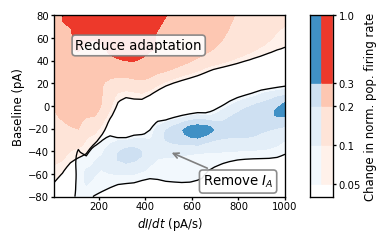

In [215]:
fig = plt.figure()

spec = gs.GridSpec(1, 2, width_ratios=[1, 0.1])
ax = plt.subplot(spec[:, 0])
ax.contour(
    *get_contour_matrices(
        deriv_in_pA_s, 
        1e3 * BASELINE_LEVELS, 
        (
            normalize_matrix(max_resp['ia']['ser']['mean']) 
            - normalize_matrix(max_resp['ctrl']['ser']['mean'])
        )
    ),
    levels=[0.05],
    colors='k'
)
ia_fax = ax.contourf(
    *get_contour_matrices(
        deriv_in_pA_s,
        1e3 * BASELINE_LEVELS, 
        (
            normalize_matrix(max_resp['ia']['ser']['mean']) 
            - normalize_matrix(max_resp['ctrl']['ser']['mean'])
        )
    ),
    levels=[0.05, 0.1, 0.2, 0.3, 1],
    cmap=plt.get_cmap('Blues')
)

ax.contour(
    *get_contour_matrices(
        deriv_in_pA_s, 
        1e3 * BASELINE_LEVELS, 
        (
            normalize_matrix(max_resp['adaptation']['ser']['mean']) 
            - normalize_matrix(max_resp['ctrl']['ser']['mean'])
        )
    ),
    levels=[0.05],
    colors='k'
)
ad_fax = ax.contourf(
    *get_contour_matrices(
        deriv_in_pA_s,
        1e3 * BASELINE_LEVELS, 
        (
            normalize_matrix(max_resp['adaptation']['ser']['mean']) 
            - normalize_matrix(max_resp['ctrl']['ser']['mean'])
        )
    ),
    levels=[0.05, 0.1, 0.2, 0.3, 1],
    cmap=plt.get_cmap('Reds')
)

annotation_box_style = dict(boxstyle="round, pad=0.25", fc="w", alpha=0.9)
ax.annotate('Reduce adaptation', (100, 50), zorder=100, bbox=annotation_box_style)
ax.annotate(
    'Remove $I_A$', (500, -40), (950, -70), 
    ha='right', zorder=100, bbox=annotation_box_style,
    arrowprops={'arrowstyle': '->'}
)

ax.set_ylabel('Baseline (pA)')
ax.set_xlabel('$dI/dt$ (pA/s)')

cbar_ax = plt.subplot(spec[:, 1])
custom_cbar(0, ia_fax.tcolors, ia_fax.levels)
custom_cbar(1, ad_fax.tcolors, ad_fax.levels)
cbar_ax.yaxis.set_ticks_position('right')
cbar_ax.yaxis.set_label_position('right')
cbar_ax.set_ylim(np.log10([0.04, 1]))
cbar_ax.set_xticks([])
cbar_ax.set_ylabel('Change in norm. pop. firing rate')

In [98]:
def get_normalizer(x):
    def normalize(arr):
        return (arr - x.min()) / (x.max() - x.min())
    return normalize

Baseline: 0.06nA


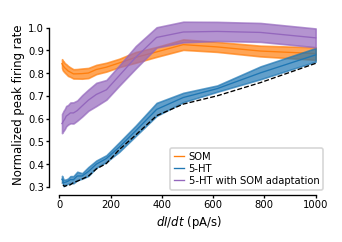

In [19]:
sweep_ = 7

for i, (cond, ct, color, label) in enumerate(zip(
    ['ctrl', 'ctrl', 'adaptation'], 
    ['som', 'ser', 'ser'],
    [colors['som'], colors['ser'], sns.color_palette()[4]],
    ['SOM', '5-HT', '5-HT with SOM adaptation']
)):
    norm = get_normalizer(max_resp[cond][ct]['mean'])
    plt.fill_between(
        deriv_in_pA_s,
        norm(max_resp[cond][ct]['mean'][sweep_, :] - max_resp[cond][ct]['std'][sweep_, :]),
        norm(max_resp[cond][ct]['mean'][sweep_, :] + max_resp[cond][ct]['std'][sweep_, :]),
        color=color,
        alpha=0.7,
        zorder=i
    )
    plt.plot(
        deriv_in_pA_s, 
        norm(max_resp[cond][ct]['mean'][sweep_, :]), 
        color=color, 
        label=label,
        zorder=i
    )
    
norm = get_normalizer(max_resp['ia']['ser']['mean'])
plt.plot(
    deriv_in_pA_s,
    norm(max_resp['ia']['ser']['mean'][sweep_, :]),
    'k--'
)
plt.legend()
#plt.ylim(-0.05, 1.05)
plt.xlabel('$dI/dt$ (pA/s)')
plt.ylabel('Normalized peak firing rate')
pltools.hide_border('tr', trim=True)

print('Baseline: {}nA'.format(BASELINE_LEVELS[sweep_]))

Baseline: 0.0nA


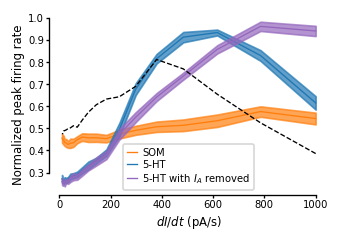

In [21]:
sweep_ = 4

for i, (cond, ct, color, label) in enumerate(zip(
    ['ctrl', 'ctrl', 'ia'], 
    ['som', 'ser', 'ser'],
    [colors['som'], colors['ser'], sns.color_palette()[4]],
    ['SOM', '5-HT', '5-HT with $I_A$ removed']
)):
    norm = get_normalizer(max_resp[cond][ct]['mean'])
    plt.fill_between(
        deriv_in_pA_s,
        norm(max_resp[cond][ct]['mean'][sweep_, :] - max_resp[cond][ct]['std'][sweep_, :]),
        norm(max_resp[cond][ct]['mean'][sweep_, :] + max_resp[cond][ct]['std'][sweep_, :]),
        color=color,
        alpha=0.7,
        zorder=i
    )
    plt.plot(
        deriv_in_pA_s, 
        norm(max_resp[cond][ct]['mean'][sweep_, :]), 
        color=color, 
        label=label,
        zorder=i
    )
    
norm = get_normalizer(max_resp['adaptation']['ser']['mean'])
plt.plot(
    deriv_in_pA_s,
    norm(max_resp['adaptation']['ser']['mean'][sweep_, :]),
    'k--'
)
plt.legend()
#plt.ylim(-0.05, 1.05)
plt.xlabel('$dI/dt$ (pA/s)')
plt.ylabel('Normalized peak firing rate')
pltools.hide_border('tr', trim=True)

print('Baseline: {}nA'.format(BASELINE_LEVELS[sweep_]))

Baseline: 0.04nA


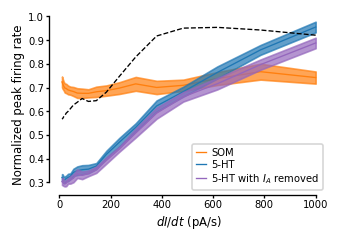

In [22]:
sweep_ = 6

for i, (cond, ct, color, label) in enumerate(zip(
    ['ctrl', 'ctrl', 'ia'], 
    ['som', 'ser', 'ser'],
    [colors['som'], colors['ser'], sns.color_palette()[4]],
    ['SOM', '5-HT', '5-HT with $I_A$ removed']
)):
    norm = get_normalizer(max_resp[cond][ct]['mean'])
    plt.fill_between(
        deriv_in_pA_s,
        norm(max_resp[cond][ct]['mean'][sweep_, :] - max_resp[cond][ct]['std'][sweep_, :]),
        norm(max_resp[cond][ct]['mean'][sweep_, :] + max_resp[cond][ct]['std'][sweep_, :]),
        color=color,
        alpha=0.7,
        zorder=i
    )
    plt.plot(
        deriv_in_pA_s, 
        norm(max_resp[cond][ct]['mean'][sweep_, :]), 
        color=color, 
        label=label,
        zorder=i
    )
    
norm = get_normalizer(max_resp['adaptation']['ser']['mean'])
plt.plot(
    deriv_in_pA_s,
    norm(max_resp['adaptation']['ser']['mean'][sweep_, :]),
    'k--'
)
plt.legend()
#plt.ylim(-0.05, 1.05)
plt.xlabel('$dI/dt$ (pA/s)')
plt.ylabel('Normalized peak firing rate')
pltools.hide_border('tr', trim=True)

print('Baseline: {}nA'.format(BASELINE_LEVELS[sweep_]))

In [12]:
def deriv_colormesh(Z, ax=None, **pltargs):
    if ax is None:
        ax = plt.gca()
        
    x = np.concatenate([[1000], (deriv_in_pA_s[1:] + deriv_in_pA_s[:-1])/2., [9]])
    y = (1e3 * np.linspace(BASELINE_LEVELS.min() - 0.01, BASELINE_LEVELS.max() + 0.01, len(BASELINE_LEVELS) + 1))
    mappable = ax.pcolormesh(x, y[2:], Z[2:], **pltargs)
    ax.set_ylabel('Baseline (pA)')
    ax.set_xlabel('$dI/dt$ (pA/s)')
    
    return mappable

Saving svg
Saving png
Done!


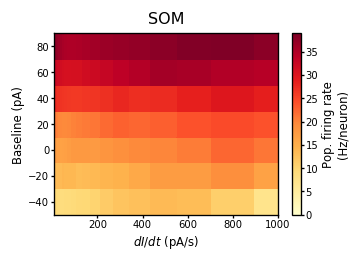

Saving svg
Saving png
Done!


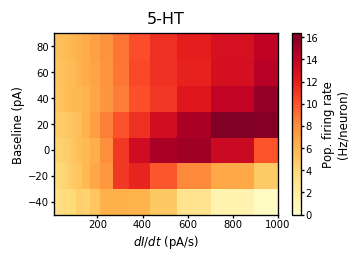

In [15]:
for ct, lab in {'ser': '5-HT', 'som': 'SOM'}.items():
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.set_title(lab)
    mappable = deriv_colormesh(
        max_resp['ctrl'][ct]['mean'], 
        ax, 
        cmap=plt.get_cmap('YlOrRd'),
        vmin=0
    )
    cbar = fig.colorbar(mappable)
    cbar.set_label('Pop. firing rate\n(Hz/neuron)')

    savefig(os.path.join(IMG_PATH, 'scratch_{}_deriv'.format(ct)))
    plt.show()

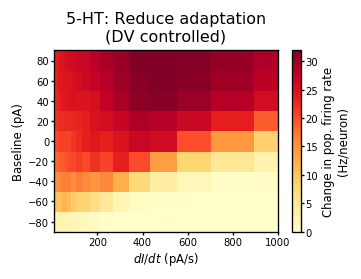

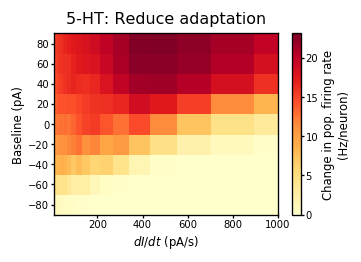

In [12]:
for (manipulation, control), (label, fname) in {
    ('adaptation', 'ctrl'): ('5-HT: Reduce adaptation', 'scratch_ser_adaptation_deriv'),
    ('dv_adaptation', 'dv'): ('5-HT: Reduce adaptation\n(DV controlled)', 'scratch_ser_dv_adaptation_deriv')
}.items():
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.set_title(label)
    mappable = deriv_colormesh(
        (max_resp[manipulation]['ser']['mean'] - max_resp[control]['ser']['mean']),
        cmap=plt.get_cmap('YlOrRd'),
        vmin=0.
    )
    cbar = fig.colorbar(mappable)
    cbar.set_label('Change in pop. firing rate\n(Hz/neuron)')

    #savefig(os.path.join(IMG_PATH, fname))

Saving svg
Saving png
Done!


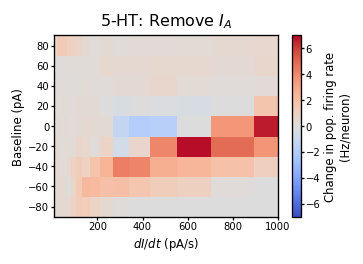

In [150]:
fig = plt.figure()
ax = plt.subplot(111)
ax.set_title('5-HT: Remove $I_A$')
mappable = deriv_colormesh(
    (max_resp['ia']['ser']['mean'] - max_resp['ctrl']['ser']['mean']),
    cmap=plt.get_cmap('coolwarm'),
    vmin=-7, vmax=7
)
cbar = fig.colorbar(mappable)
cbar.set_label('Change in pop. firing rate\n(Hz/neuron)')

savefig(os.path.join(IMG_PATH, 'scratch_ser_ia_deriv'))

---

In [64]:
def mark_outline(
    Z, threshold, edgecolor='k', fillcolor='red', ax=None, fill_params={}, edge_params={}
):
    """Contour the area of Z that's above threshold."""
    if ax is None:
        ax = plt.gca()
        
    ax.contourf(
        deriv_in_pA_s,
        1e3 * BASELINE_LEVELS,
        Z,
        colors=(fillcolor,),
        levels=(threshold, np.inf),
        **fill_params
    )
    if edgecolor is not None:
        ax.contour(
            deriv_in_pA_s,
            1e3 * BASELINE_LEVELS,
            Z,
            colors=(edgecolor,),
            levels=(threshold),
            **edge_params
        )
        
def mark_contours(Z, threshold, interval, ax=None, **pltargs):
    if ax is None:
        ax = plt.gca()
        
    levels = np.arange(threshold, Z.max(), interval)
    
    ax.contour(
        deriv_in_pA_s,
        1e3 * BASELINE_LEVELS,
        Z,
        levels=levels,
        **pltargs
    )
    

def round_up(value, factor, starting_from=0):
    """Round a value up to the nearest multiple of a given factor."""
    assert starting_from < value
    assert factor < (value - starting_from)
    return factor * (1 + ((value - starting_from) // factor)) + starting_from

def mark_contours_colorbar(values, ax=None, **pltargs):
    if ax is None:
        ax = plt.gca()
        
    for val in values:
        ax.axhline(val, **pltargs)

Saving svg
Saving png
Done!


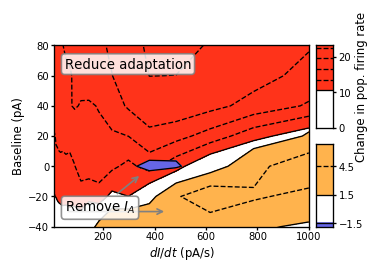

In [141]:
spec = gs.GridSpec(2, 2, width_ratios=(1, 0.07), wspace=0.05)

plt.subplot(spec[:, 0])
# Mark effect of adaptation
mark_outline(
    max_resp['adaptation']['ser']['mean'] - max_resp['ctrl']['ser']['mean'],
    10.5,
    fillcolor=(1, 0.2, 0.1)
)
mark_contours(
    max_resp['adaptation']['ser']['mean'] - max_resp['ctrl']['ser']['mean'],
    10.5 + 3,
    3,
    linestyles='--',
    colors='k'
)

# Mark effect of removing IA
# Negative part of IA KO first.
mark_outline(
    -(max_resp['ia']['ser']['mean'] - max_resp['ctrl']['ser']['mean']), 
    1.5,
    fillcolor=(0.4, 0.4, 0.9),
    fill_params={'zorder': 10},
    edge_params={'zorder': 11}
)
mark_contours(  # Doesn't do anything because effect is too small.
    -(max_resp['ia']['ser']['mean'] - max_resp['ctrl']['ser']['mean']),
    1.5 + 3,
    3,
    linestyles='--',
    colors='k',
    zorder=12
)

# Positive part of IA KO
mark_outline(
    max_resp['ia']['ser']['mean'] - max_resp['ctrl']['ser']['mean'], 
    1.5,
    fillcolor=(1, 0.7, 0.3)
)
mark_contours(
    max_resp['ia']['ser']['mean'] - max_resp['ctrl']['ser']['mean'],
    1.5 + 3,
    3,
    linestyles='--',
    colors='k'
)

# Annotations
annotation_box_style = dict(boxstyle="round, pad=0.25", fc="w", alpha=0.85)
plt.annotate('Reduce adaptation', (50, 65), bbox=annotation_box_style)
plt.annotate(
    '', (450, -30), (50, -30),
    arrowprops={'arrowstyle': '->'}
)
plt.annotate(
    'Remove $I_A$', (350, -5), (50, -30), bbox=annotation_box_style,
    arrowprops={'arrowstyle': '->'}
)

plt.ylim(-40, 80)
plt.ylabel('Baseline (pA)')
plt.xlabel('$dI/dt$ (pA/s)')

# Subplots for color bars.
plt.subplot(spec[0, 1])
max_val = (max_resp['adaptation']['ser']['mean'] - max_resp['ctrl']['ser']['mean']).max()
plt.fill_between(
    [0, 1], 
    [10.5] * 2, 
    [round_up(max_val, 3, 1.5)] * 2,
    color=(1, 0.2, 0.1)
)
mark_contours_colorbar([10.5], ls='-', color='k')
mark_contours_colorbar(np.arange(10.5 + 3, max_val, 3), ls='--', color='k')
plt.ylim(
    0, 
    max_val
)
plt.gca().yaxis.set_ticks_position('right')
plt.xticks([])
plt.ylabel('Change in pop. firing rate')
plt.gca().yaxis.set_label_position('right')

plt.subplot(spec[1, 1])
max_val = (max_resp['ia']['ser']['mean'] - max_resp['ctrl']['ser']['mean']).max()
min_val = (max_resp['ia']['ser']['mean'] - max_resp['ctrl']['ser']['mean']).min()

plt.fill_between(
    [0, 1],
    [1.5] * 2,
    [round_up(max_val, 3, 1.5)],
    color=(1, 0.7, 0.3)
)
mark_contours_colorbar([1.5], ls='-', color='k')
mark_contours_colorbar([4.5], ls='--', color='k')
plt.fill_between(
    [0, 1],
    [-1.5] * 2,
    [min_val] * 2,
    color=(0.4, 0.4, 0.9)
)
mark_contours_colorbar([-1.5], ls='-', color='k')
plt.gca().yaxis.set_ticks_position('right')
plt.ylim(min_val, max_val)
plt.yticks(np.arange(-1.5, max_val, 3))
plt.xticks([])

if IMG_PATH is not None:
    savefig(os.path.join(IMG_PATH, 'dv_multi_manipulation_contour'))

---

In [127]:
def get_normalizer(x):
    """Get a function that normalizes an array to the max of this function's argument."""
    max_value = np.max(x)
    def normalize(arr):
        return np.asarray(arr) / max_value
    return normalize

def plot_mean_std(mean, std, ax=None, normalize=True, fill_args={}, line_args={}, **pltargs):
    if ax is None:
        ax = plt.gca()
        
    # Set common options.
    fill_args.update(pltargs)
    line_args.update(pltargs)
    
    # Optionally normalize the data using a function 'norm'
    # If normalization is off, 'norm' is identity
    if normalize:
        norm = get_normalizer(mean)
    else:
        norm = lambda x: x
    
    ax.fill_between(
        deriv_in_pA_s,
        norm(mean - std),
        norm(mean + std),
        **fill_args
    )
    ax.plot(
        deriv_in_pA_s,
        norm(mean),
        **line_args
    )

def patch_axes():
    plt.legend()
    plt.ylim(min(0, plt.ylim()[0]))
    plt.xlabel('$dI/dt$ (pA/s)')
    plt.ylabel('Normalized peak firing rate')
    pltools.hide_border('tr', trim=True)

Saving svg
Saving png
Done!
Saving svg
Saving png
Done!
Saving svg
Saving png
Done!
Saving svg
Saving png
Done!
Saving svg
Saving png
Done!
Saving svg
Saving png
Done!


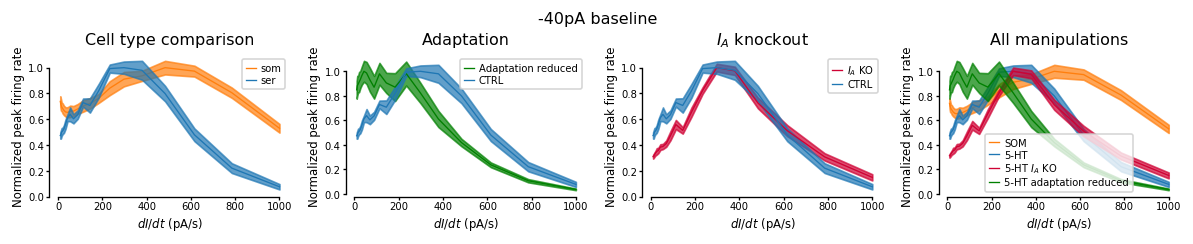

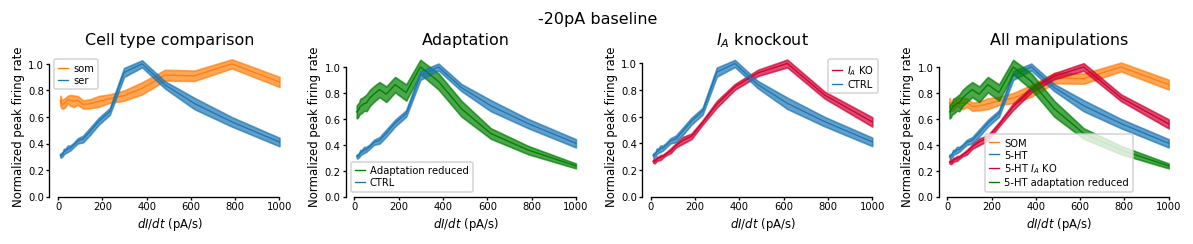

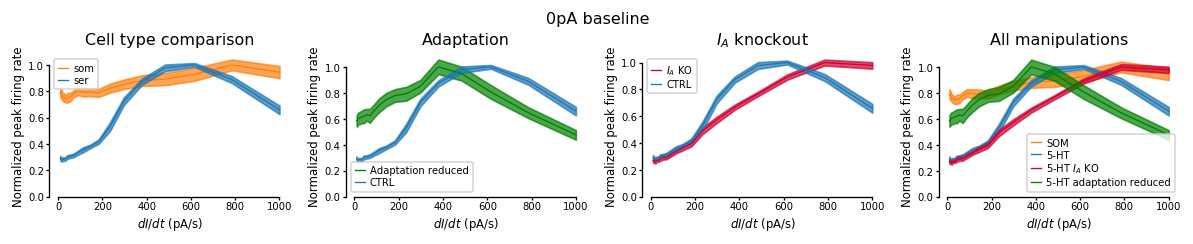

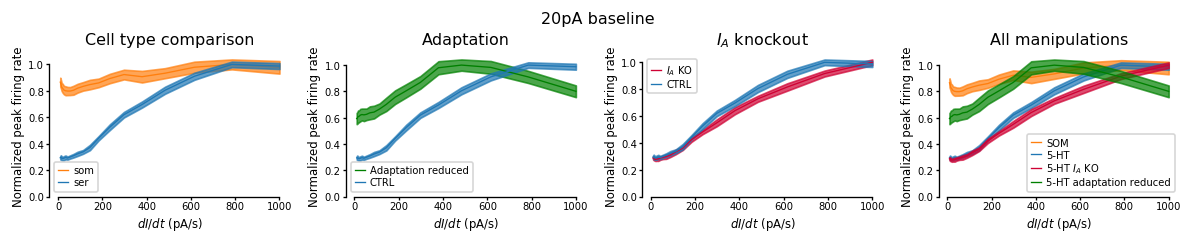

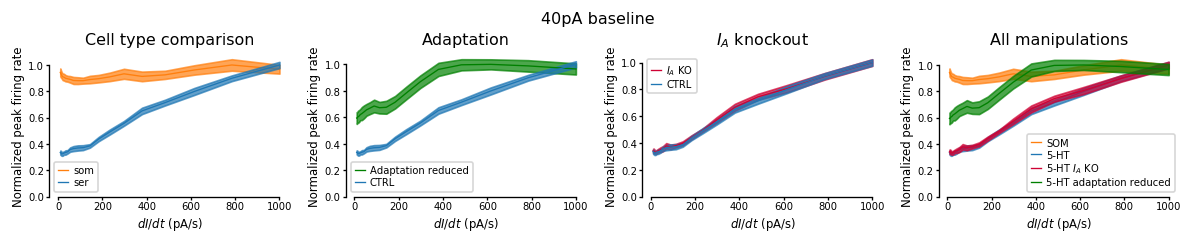

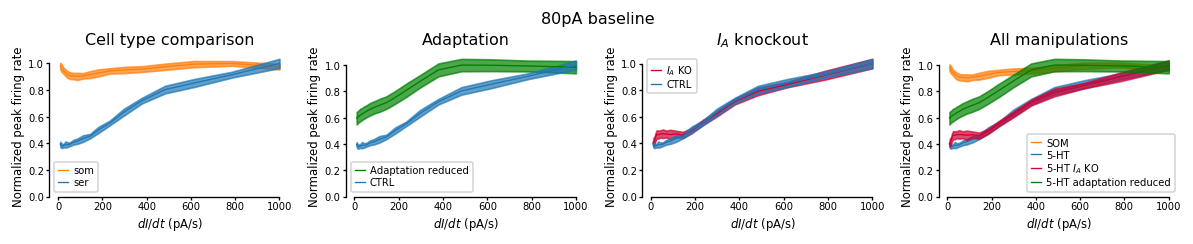

In [143]:
for sweep_ in [2, 3, 4, 5, 6, 8]:
    plt.figure(figsize=(10, 2))
    plt.suptitle('{}pA baseline'.format(int(1e3 * BASELINE_LEVELS[sweep_])))
    
    plt.subplot(141)
    plt.title('Cell type comparison')
    for i, ct in enumerate(['som', 'ser']):
        plot_mean_std(
            max_resp['ctrl'][ct]['mean'][sweep_, :],
            max_resp['ctrl'][ct]['std'][sweep_, :],
            color=colors[ct],
            zorder=i,
            fill_args={'alpha': 0.7},
            line_args={'label': ct}
        )
    patch_axes()

    plt.subplot(142)
    plt.title('Adaptation')
    for cond, (label, color) in {
        'ctrl': ('CTRL', colors['ser']), 
        'adaptation': ('Adaptation reduced', 'g'),
    }.items():
        plot_mean_std(
            max_resp[cond]['ser']['mean'][sweep_, :],
            max_resp[cond]['ser']['std'][sweep_, :],
            color=color,
            zorder=i,
            fill_args={'alpha': 0.7},
            line_args={'label': label}
        )
    patch_axes()
        
    plt.subplot(143)
    plt.title('$I_A$ knockout')
    for cond, (label, color) in {
        'ctrl': ('CTRL', colors['ser']), 
        'ia': ('$I_A$ KO', colors['4AP']),
    }.items():
        plot_mean_std(
            max_resp[cond]['ser']['mean'][sweep_, :],
            max_resp[cond]['ser']['std'][sweep_, :],
            color=color,
            zorder=i,
            fill_args={'alpha': 0.7},
            line_args={'label': label}
        )
    patch_axes()
    
    plt.subplot(144)
    plt.title('All manipulations')
    for i, ((cond, ct), (label, color)) in enumerate({
        ('ctrl', 'ser'): ('5-HT', colors['ser']), 
        ('ctrl', 'som'): ('SOM', colors['som']),
        ('ia', 'ser'): ('5-HT $I_A$ KO', colors['4AP']),
        ('adaptation', 'ser'): ('5-HT adaptation reduced', 'g')
    }.items()):
        plot_mean_std(
            max_resp[cond][ct]['mean'][sweep_, :],
            max_resp[cond][ct]['std'][sweep_, :],
            color=color,
            zorder=i,
            fill_args={'alpha': 0.7},
            line_args={'label': label}
        )
    patch_axes()
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.8)
    
    savefig(os.path.join(IMG_PATH, 'deriv_lineplots', 'sweep_{}'.format(sweep_)))

---

---

In [151]:
def r_squared(x, y):
    sum_sq_residuals = np.polyfit(x, y, 1, full=True)[1]
    total_var = np.var(y) * len(y)
    return 1 - sum_sq_residuals / total_var

In [166]:
def plot_gain_and_uncertainty(x, y_arr, ax=None, **pltargs):
    interp_x = np.linspace(10, 1000, 10)
    interp_y = np.apply_along_axis(lambda vec: np.interp(interp_x, deriv_in_pA_s[::-1], vec[::-1]), 1, y_arr)
    gain = np.apply_along_axis(lambda vec: np.polyfit(interp_x, vec, 1)[0], 1, interp_y)
    rsq = np.apply_along_axis(lambda vec: r_squared(interp_x, vec), 1, interp_y)
    
    if ax is None:
        ax= plt.gca()
    
    label = pltargs.pop('label', None)
    ax.plot(x, gain, label=label, **pltargs)
    for x_pt, gain_pt, rsq_pt in zip(x, gain, rsq):
        ax.plot(x_pt, gain_pt, 'o', alpha=rsq_pt, **pltargs)

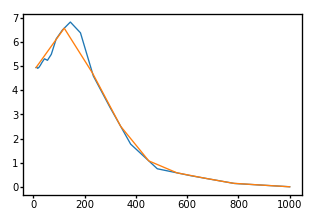

In [163]:
plt.plot(deriv_in_pA_s, max_resp['ctrl']['som']['mean'][0, :])
plt.plot(np.linspace(10, 1000, 10), np.interp(np.linspace(10, 1000, 10), deriv_in_pA_s[::-1], max_resp['ctrl']['som']['mean'][0, ::-1]))

In [159]:
deriv_in_pA_s

array([1000.        ,  784.75997035,  615.84821107,  483.29302386,
        379.26901907,  297.63514416,  233.57214691,  183.29807108,
        143.84498883,  112.88378917,   88.58667904,   69.51927962,
         54.55594781,   42.81332399,   33.59818286,   26.36650899,
         20.69138081,   16.23776739,   12.74274986,   10.        ])

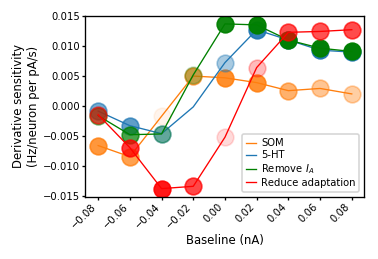

In [167]:
plot_gain_and_uncertainty(BASELINE_LEVELS, max_resp['ctrl']['som']['mean'], color=colors['som'], markersize=10, label='SOM')
plot_gain_and_uncertainty(BASELINE_LEVELS, max_resp['ctrl']['ser']['mean'], color=colors['ser'], markersize=10, label='5-HT')
plot_gain_and_uncertainty(BASELINE_LEVELS, max_resp['ia']['ser']['mean'], color='green', markersize=10, label='Remove $I_A$')
plot_gain_and_uncertainty(BASELINE_LEVELS, max_resp['adaptation']['ser']['mean'], color='red', markersize=10, label='Reduce adaptation')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.xlabel('Baseline (nA)')
plt.ylabel('Derivative sensitivity\n(Hz/neuron per pA/s)')

plt.savefig(os.path.join(IMG_PATH, 'scratch_deriv_lineplot.png'), dpi=600, bbox_inches='tight')

---

In [42]:
def max_norm(x):
    return x / x.max()

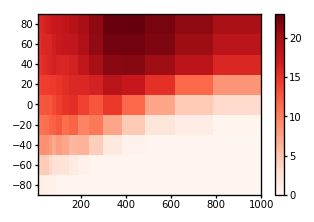

In [78]:
fig = plt.figure()
ax = plt.subplot(111)
padded_x = np.concatenate([deriv_in_pA_s, [0]])
mappable = plt.pcolormesh(
    deriv_in_pA_s, 
    1e3 * np.linspace(BASELINE_LEVELS.min() - 0.01, BASELINE_LEVELS.max() + 0.01, len(BASELINE_LEVELS) + 1), 
    ((max_resp['adaptation']['ser']['mean']) 
        - (max_resp['ctrl']['ser']['mean'])),
    cmap=plt.get_cmap('Reds'),
    shading='nearest',
)
fig.colorbar(mappable)

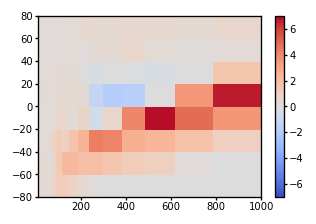

In [50]:
fig = plt.figure()
ax = plt.subplot(111)
mappable = plt.pcolormesh(
    deriv_in_pA_s, 
    1e3 * BASELINE_LEVELS, 
    ((max_resp['ia']['ser']['mean']) 
        - (max_resp['ctrl']['ser']['mean'])),
    cmap=plt.get_cmap('coolwarm'),
    vmin=-7, vmax=7
)
fig.colorbar(mappable)

In [24]:
from matplotlib.colors import LinearSegmentedColormap

"mappable = plt.pcolormesh(\n    deriv_in_pA_s, \n    1e3 * BASELINE_LEVELS, \n    np.sqrt(np.abs(normalize_matrix(max_resp['ia']['ser']['mean']) \n        - normalize_matrix(max_resp['ctrl']['ser']['mean'])) * np.abs(normalize_matrix(max_resp['adaptation']['ser']['mean']) \n        - normalize_matrix(max_resp['ctrl']['ser']['mean']))),\n    cmap=LinearSegmentedColormap.from_list('my_map', [(0, 1, 0, 0), (0, 1, 0, 1)]),\n)"

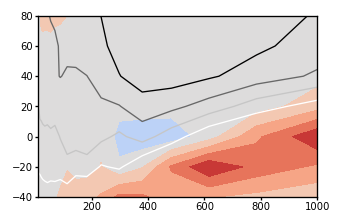

In [59]:
fig = plt.figure()
ax = plt.subplot(111)
mappable = plt.contourf(
    deriv_in_pA_s, 
    1e3 * BASELINE_LEVELS, 
    ((max_resp['ia']['ser']['mean']) 
        - (max_resp['ctrl']['ser']['mean'])),
    cmap=plt.get_cmap('coolwarm'),#LinearSegmentedColormap.from_list('my_map', [(1, 0, 0, 0), (1, 0, 0, 1)]),
    edgecolors='none',
    levels=np.linspace(-7, 7, 10)
)
mappable = plt.contour(
    deriv_in_pA_s, 
    1e3 * BASELINE_LEVELS, 
    ((max_resp['adaptation']['ser']['mean']) 
        - (max_resp['ctrl']['ser']['mean'])),
    cmap=plt.get_cmap('Greys'),#LinearSegmentedColormap.from_list('my_other_map',[(0, 0, 1, 0), (0, 0, 1, 1)],),
    levels=np.linspace(10, 30, 7)
)
plt.ylim(-40, 80)
"""mappable = plt.pcolormesh(
    deriv_in_pA_s, 
    1e3 * BASELINE_LEVELS, 
    np.sqrt(np.abs(normalize_matrix(max_resp['ia']['ser']['mean']) 
        - normalize_matrix(max_resp['ctrl']['ser']['mean'])) * np.abs(normalize_matrix(max_resp['adaptation']['ser']['mean']) 
        - normalize_matrix(max_resp['ctrl']['ser']['mean']))),
    cmap=LinearSegmentedColormap.from_list('my_map', [(0, 1, 0, 0), (0, 1, 0, 1)]),
)"""
#fig.colorbar(mappable)

(-40, 80)

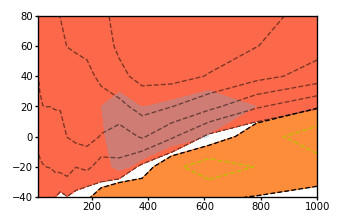

In [108]:
fig = plt.figure()
ax = plt.subplot(111)


mappable = plt.contourf(
    deriv_in_pA_s, 
    1e3 * BASELINE_LEVELS, 
    ((max_resp['ia']['ser']['mean']) 
        - (max_resp['ctrl']['ser']['mean'])),
    cmap=plt.get_cmap('Oranges'),#LinearSegmentedColormap.from_list('my_map', [(1, 0, 0, 0), (1, 0, 0, 1)]),
    edgecolors='none',
    levels= [2, 7]
)
mappable = plt.contour(
    deriv_in_pA_s, 
    1e3 * BASELINE_LEVELS, 
    ((max_resp['ia']['ser']['mean']) 
        - (max_resp['ctrl']['ser']['mean'])),
    #cmap=plt.get_cmap('Reds'),#LinearSegmentedColormap.from_list('my_map', [(1, 0, 0, 0), (1, 0, 0, 1)]),
    colors='k',
    linestyles='--',
    #edgecolors='none',
    levels=[2.]
)
mappable = plt.contour(
    deriv_in_pA_s, 
    1e3 * BASELINE_LEVELS, 
    ((max_resp['ia']['ser']['mean']) 
        - (max_resp['ctrl']['ser']['mean'])),
    #cmap=plt.get_cmap('Reds'),#LinearSegmentedColormap.from_list('my_map', [(1, 0, 0, 0), (1, 0, 0, 1)]),
    colors='y',
    linestyles='--',
    #edgecolors='none',
    levels=[5.]
)
mappable = plt.contourf(
    deriv_in_pA_s, 
    1e3 * BASELINE_LEVELS, 
    ((max_resp['adaptation']['ser']['mean']) 
        - (max_resp['ctrl']['ser']['mean'])),
    cmap=plt.get_cmap('Reds'),#LinearSegmentedColormap.from_list('my_other_map',[(1, 1, 1, 0), (1, 1, 1, 1)],),
    levels=[8, 30],
)
mappable = plt.contourf(
    deriv_in_pA_s, 
    1e3 * BASELINE_LEVELS, 
    ((max_resp['ia']['ser']['mean']) 
        - (max_resp['ctrl']['ser']['mean'])),
    cmap=plt.get_cmap('Blues'),#LinearSegmentedColormap.from_list('my_map', [(1, 0, 0, 0), (1, 0, 0, 1)]),
    edgecolors='none',
    levels=[-7, -0.0000001],
    alpha=0.3
)
mappable = plt.contour(
    deriv_in_pA_s, 
    1e3 * BASELINE_LEVELS, 
    ((max_resp['adaptation']['ser']['mean']) 
        - (max_resp['ctrl']['ser']['mean'])),
    #cmap=plt.get_cmap('Greys_r'),#LinearSegmentedColormap.from_list('my_other_map',[(1, 1, 1, 0), (1, 1, 1, 1)],),
    colors='k',
    levels=np.linspace(8, 30, 8),
    linestyles='--',
    alpha=0.5
)
plt.ylim(-40, 80)
#fig.colorbar(mappable)

In [90]:
np.linspace(8, 30, 8)

array([ 8.        , 11.14285714, 14.28571429, 17.42857143, 20.57142857,
       23.71428571, 26.85714286, 30.        ])

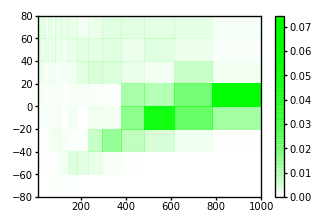

In [73]:
fig = plt.figure()
ax = plt.subplot(111)
mappable = plt.pcolormesh(
    deriv_in_pA_s, 
    1e3 * BASELINE_LEVELS, 
    np.abs(normalize_matrix(max_resp['ia']['ser']['mean']) 
        - normalize_matrix(max_resp['ctrl']['ser']['mean'])) * np.abs(normalize_matrix(max_resp['adaptation']['ser']['mean']) 
        - normalize_matrix(max_resp['ctrl']['ser']['mean'])),
    cmap=LinearSegmentedColormap.from_list('my_map', [(0, 1, 0, 0), (0, 1, 0, 1)]),
)

fig.colorbar(mappable)

In [162]:
max_resp[cond][ct]['mean'][5, :]

array([24.56670437, 27.91671391, 30.14004765, 30.67671871, 30.05504942,
       26.64171371, 24.68337507, 23.18503809, 21.52003841, 20.42337141,
       19.72003765, 19.54337034, 19.20003676, 19.07503819, 19.14670448,
       19.01336946, 18.73503404, 18.650035  , 18.33502857, 18.21667036])

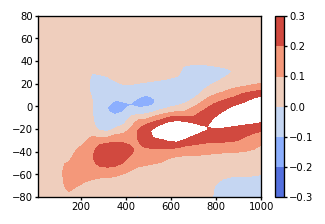

In [226]:
norm = get_normalizer(max_resp['ctrl']['ser']['mean'])
cbar = plt.figure().colorbar(interpolated_contour(
    deriv_in_pA_s, 
    1e3 * BASELINE_LEVELS, 
    (
        norm(max_resp['ia']['ser']['mean'])
        - norm(max_resp['ctrl']['ser']['mean'])
    ), 
    levels=np.array([-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3]),
    cmap=plt.get_cmap('coolwarm')
))


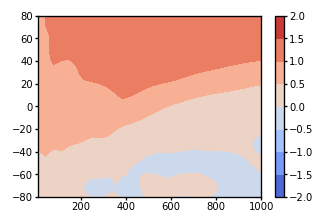

In [235]:
norm = get_normalizer(max_resp['ctrl']['ser']['mean'])
cbar = plt.figure().colorbar(interpolated_contour(
    deriv_in_pA_s, 
    1e3 * BASELINE_LEVELS, 
    (
        norm(max_resp['adaptation']['ser']['mean'])
        - norm(max_resp['ctrl']['ser']['mean'])
    ), 
    levels=np.array([-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]),
    cmap=plt.get_cmap('coolwarm')
))


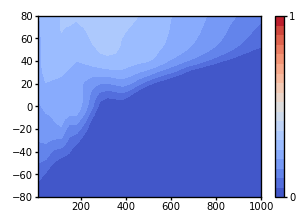

In [110]:
cbar = plt.figure().colorbar(interpolated_contour(
    deriv_in_pA_s, 
    1e3 * BASELINE_LEVELS, 
    (
        normalize_matrix(max_resp['adaptation']['ser']['mean']) 
        - normalize_matrix(max_resp['ctrl']['ser']['mean'])
    ), 
    levels=np.linspace(0, 1, 20)
))
cbar.set_ticks([-1, 0, 1])

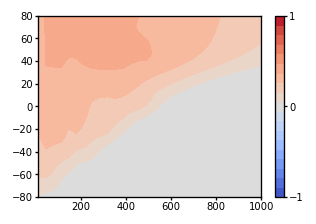

In [30]:
cbar = plt.figure().colorbar(interpolated_contour(
    deriv_in_pA_s, 
    1e3 * BASELINE_LEVELS, 
    (
        normalize_matrix(max_resp['dv_adaptation']['ser']['mean']) 
        - normalize_matrix(max_resp['dv']['ser']['mean'])
    ), 
    levels=np.linspace(-1, 1, 20)
))
cbar.set_ticks([-1, 0, 1])

---

In [13]:
sample_trace_model, sample_trace_psth = sim_df.loc[
    (sim_df['Baseline level'] == BASELINE_LEVELS[5]) & (sim_df['Rep'] == 0), ['Model', 'Principal PSTH']
].iloc[0, :]

In [14]:
with open(os.path.join(DATA_PATH, '0.020_baseline', 'input.dat'), 'rb') as f:
    input_arr = pickle.load(f)
    f.close()

In [15]:
SWEEPS_TO_SHOW = [0, 5, 10]
TIME_SLICE = slice(19000, 35000)
TIME_VEC = np.arange(0, TIME_SLICE.stop - TIME_SLICE.start) * input_arr['metaparams']['dt'] * 1e-3

/home/eharkin/miniconda3/envs/neopozz/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


Saving svg
Saving png
Done!


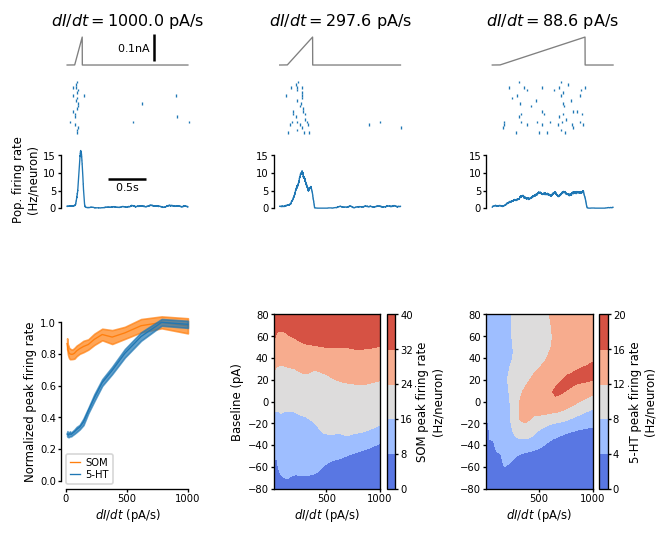

In [16]:
fig = plt.figure(figsize=(6, 5))

spec = gs.GridSpec(2, 3, hspace=0.6, wspace=0.6)

for i, sweep in enumerate(SWEEPS_TO_SHOW):
    ax = plt.subplot(spec[0, i])
    
    trace_spec = gs.GridSpecFromSubplotSpec(3, 3, spec[0, i], height_ratios=[0.5, 1, 1])
    
    plt.subplot(trace_spec[0, :])
    plt.title('$dI/dt = {:.1f}$ pA/s'.format(1e3 * input_arr['metaparams']['deriv_in_nA_s'][sweep]))
    plt.plot(TIME_VEC, input_arr['ser_input'][sweep, 0, TIME_SLICE].T, color=colors['input'])
    if i == 0:
        pltools.add_scalebar(
            y_size=0.1,
            y_units='nA',
            omit_x=True,
            round=False,
            anchor=(0.7, 0.1),
            linewidth=sbarlw
        )
    else:
        pltools.hide_border()
        pltools.hide_ticks()
    
    plt.subplot(trace_spec[1, :])
    plt.eventplot(
        [np.where(sample_trace_model.ser_spktrains[sweep, j, TIME_SLICE])[0] * 0.1 * 1e-3 for j in range(20)],
        color=colors['ser']
    )
    plt.xlim(0, TIME_VEC[-1])
    pltools.hide_ticks()
    pltools.hide_border('a')
    
    plt.subplot(trace_spec[2, :])
    plt.plot(TIME_VEC, sample_trace_psth[sweep, TIME_SLICE].T, color=colors['ser'])
    plt.ylim(-0.5, 17)
    plt.yticks([0, 5, 10, 15])
    if i == 0:
        plt.ylabel('Pop. firing rate\n(Hz/neuron)')
        pltools.add_scalebar(
            x_size=0.5, 
            x_units='s', 
            anchor=(0.7, 0.5), 
            round=False, 
            omit_y=True, 
            remove_frame=False,
            linewidth=sbarlw
        )
    pltools.hide_border('trb', trim=True)



plt.subplot(spec[1, 0])
for i, (label, key) in enumerate(zip(['SOM', '5-HT'], ['som', 'ser'])):
    def normalize(x):
        return x / max_resp[key][5, :].max()
    
    plt.fill_between(
        deriv_in_pA_s,
        normalize(max_resp[key][5, :] - max_resp_std[key][5, :]),
        normalize(max_resp[key][5, :] + max_resp_std[key][5, :]),
        color=colors[key],
        alpha=0.7,
        zorder=i
    )
    plt.plot(
        deriv_in_pA_s, 
        normalize(max_resp[key][5, :]), 
        color=colors[key], 
        label=label,
        zorder=i
    )
plt.legend()
plt.ylim(-0.05, 1.05)
plt.xlabel('$dI/dt$ (pA/s)')
plt.ylabel('Normalized peak firing rate')
pltools.hide_border('tr', trim=True)


som_ax = plt.subplot(spec[1, 1])
som_cbar = fig.colorbar(
    interpolated_contour(
        deriv_in_pA_s, 
        1e3 * BASELINE_LEVELS, 
        max_resp['som'], 
        ax=som_ax,
        levels=np.linspace(0, 40, 6)
    )
)
som_cbar.ax.set_ylabel('SOM peak firing rate\n(Hz/neuron)')
som_ax.set_ylabel('Baseline (pA)')
som_ax.set_xlabel('$dI/dt$ (pA/s)')


raw_ax = plt.subplot(spec[1, 2])
raw_cbar = fig.colorbar(
    interpolated_contour(
        deriv_in_pA_s, 
        1e3 * BASELINE_LEVELS, 
        max_resp['ser'], 
        ax=raw_ax, 
        levels=np.linspace(0, 20, 6)
    )
)
raw_cbar.ax.set_ylabel('5-HT peak firing rate\n(Hz/neuron)')
#raw_ax.set_ylabel('Baseline (pA)')
raw_ax.set_xlabel('$dI/dt$ (pA/s)')

plt.tight_layout()

if IMG_PATH is not None:
    savefig(os.path.join(IMG_PATH, 'derivative_filter'))